In [ ]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sb
!{sys.executable} -m pip install pandas_profiling
sb.set()


In [2]:
## edit this section accordingly
df = pd.read_csv(r"<system>/sc1015-project/dataset/fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:

df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 1. Exploring `telecommuting`

`telecommuting` represents that it is a remote job

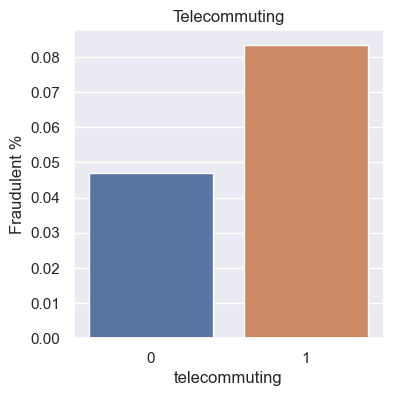

In [3]:
tmp = df.groupby('telecommuting').mean()['fraudulent']
plt.figure(figsize=(4,4))
sb.set(font_scale=1.0)
sb.barplot(x=tmp.index, y=tmp)

plt.title('Telecommuting')
plt.ylabel('Fraudulent %')
plt.show()

#print(pd.concat([df['fraudulent'], df['telecommuting']], axis = 1).reindex(df['fraudulent'].index).corr())

#### We can deduce that:

Based on the dataset, jobs that allow telecommuting are almost twice as likely to be fraudulent.

### 2. Exploring `required_education`

`required_education` represents the minimum required level of formal education for the job

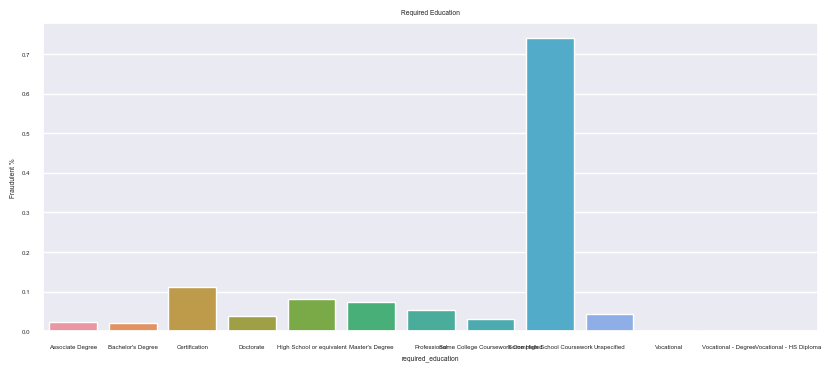

In [4]:
tmp = df.groupby('required_education').mean()['fraudulent']
plt.figure(figsize=(10,4))
sb.set(font_scale=0.4)
sb.barplot(x=tmp.index, y=tmp)
plt.title('Required Education')
plt.ylabel('Fraudulent %')
plt.show()

#### We can deduce that:

Based on the dataset, jobs that require "some high school coursework" are by far the most likely to be fraudulent

### 3. Exploring `has_company_logo` and `has_questions`

`has_company_logo` and `has_questions` represent the presence (or absence) of a company logo and questions respectively

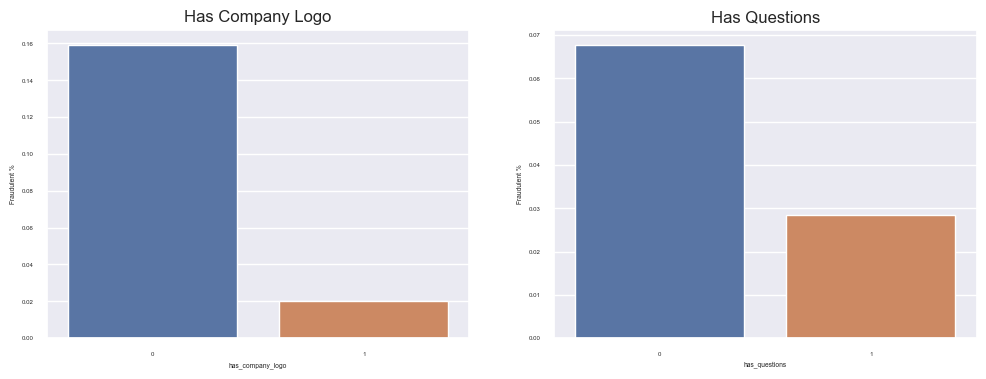

In [5]:
# Group data by 'has_company_logo'
tmp1 = df.groupby('has_company_logo').mean()['fraudulent']

# Group data by 'has_questions'
tmp2 = df.groupby('has_questions').mean()['fraudulent']

# Create subplots
fig, ax = plt.subplots(1,2, figsize=(12,4))

# Set font scale
sb.set(font_scale=1.0)

# Bar plot for 'has_company_logo'
sb.barplot(x=tmp1.index, y=tmp1, ax=ax[0])
ax[0].set_title('Has Company Logo')
ax[0].set_ylabel('Fraudulent %')

# Bar plot for 'has_questions'
sb.barplot(x=tmp2.index, y=tmp2, ax=ax[1])
ax[1].set_title('Has Questions')
ax[1].set_ylabel('Fraudulent %')

plt.show()

#### We can deduce that:

Based on the dataset, jobs that have no logo or no questions are more likely to be fraudulent.

### 4. Exploring `salary_range`

`salary_range` represents the salary range provided by the job listing. In order to evaluate the distribution of fraudulent jobs vs salary, jobs that provide a salary range will be modified to use a median value instead.

9-Dec;3-Apr;4-Apr;Oct-15;8-Sep;4-Jun;10-Oct;Oct-20;Jun-18;10-Oct;11-Nov;10-Nov;10-Oct;10-Nov;10-Oct;10-Nov;11-Dec;2-Apr;10-Nov;10-Oct;11-Nov;2-Jun;Oct-20;10-Oct;10-Nov;Dec-25;

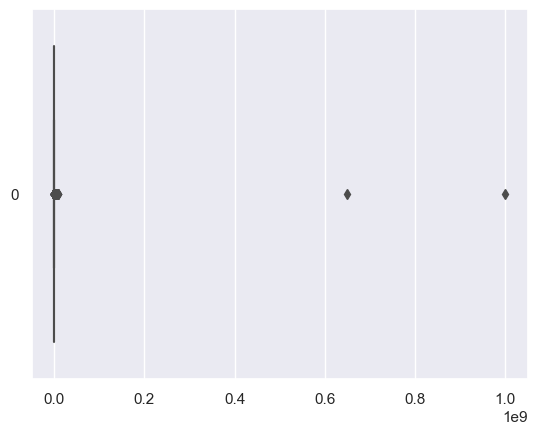

In [6]:
df['salary_range']=df['salary_range'].fillna("N/A")
val = df['salary_range'].copy()
for k,value in enumerate(val):
    if isinstance(value,str) and "-" in value: 
        #only changes data that is only in range
        min_max=value.split('-')
        try:
            minimum=int(min_max[0])
            maximum=int(min_max[1])
            #find the median
            val[k]=(minimum+maximum)/2
        except ValueError:
            print(value,end=';')
            val[k]="INVALID"
df['salary_range']=val

salary=df[df['salary_range']!="N/A"]
salary=salary[salary['salary_range']!="INVALID"]
salary=np.array(salary['salary_range'],dtype='float32')


sb.boxplot(data = salary, orient = "h")
plt.show()

We can see that there are some outliers that massively skew the boxplot, hence they will be removed.

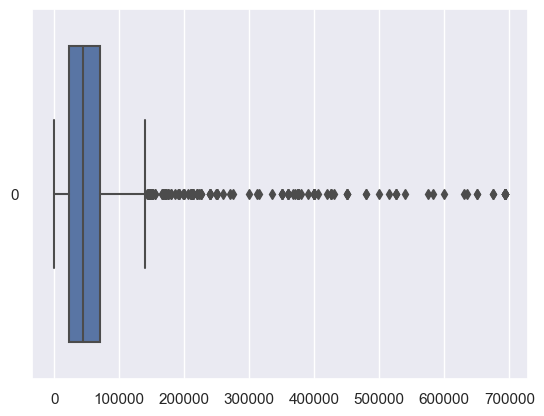

In [7]:
salary=df[df['salary_range']!="N/A"]
salary=salary[salary['salary_range']!="INVALID"]['salary_range'].astype('float32')
salary=salary[salary<=salary.quantile(0.99)]
salary=np.array(salary)

sb.boxplot(data = salary, orient = "h")
plt.show()

Despite removing the extreme outliers, the data is still very skewed.

In [8]:
df_fullsalary=df[df['salary_range']!='N/A']
df_fullsalary=df_fullsalary[df_fullsalary['salary_range']!='INVALID']
df_fullsalary['salary_range']=pd.Series(df_fullsalary['salary_range'],dtype='float32')


quantile_range=[(i+1)/5 for i in range(5)]
interval = [df_fullsalary['salary_range'].quantile(i) for i in quantile_range]
salary_type=['very_low','low','medium','medium_high','high','very_high']


new_interval=[0]+interval[:-1]+[df_fullsalary.quantile(0.98)['salary_range'],df_fullsalary.quantile(1)['salary_range']]

#Divide into groups
salary=df['salary_range'].values
for k,value in enumerate(salary):
    if not isinstance(value,str):
        for i in range(len(new_interval)-1):
            if new_interval[i]<=value<=new_interval[i+1]:
                salary[k]=salary_type[i]
                
print("Salary distributions")
df['salary_range'].value_counts()

Salary distributions


N/A            15012
medium           586
medium_high      581
very_low         563
low              540
high             513
very_high         58
INVALID           26
40000              1
Name: salary_range, dtype: int64

The salary is grouped into "classes" based on their quantile.
 

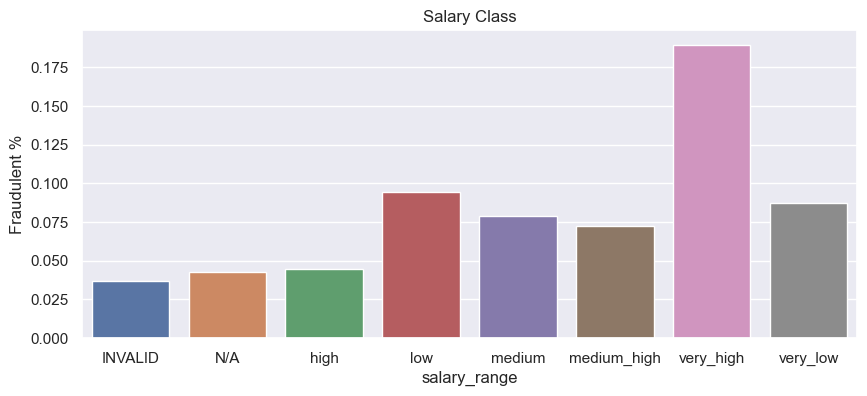

In [9]:
#changing 4000 into medium
df.loc[df['salary_range']=='40000','salary_range']='INVALID'

tmp = df.groupby('salary_range').mean()['fraudulent']
plt.figure(figsize=(10,4))
sb.set(font_scale=1.0)
sb.barplot(x=tmp.index, y=tmp)
plt.title('Salary Class')
plt.ylabel('Fraudulent %')
plt.show()

It can be observed that the very_high class has the most number of fraudulent.

In [1]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
            
        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))